## Combining unity VR data with imaging data
Temporal alignment using recrded microscope frame trigger signal in unity log

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from unityvr.preproc import logproc
from unityvr.viz import viz
from os.path import sep

#### Load preprocessed VR and imaging data

In [2]:
preprocDir = '../../../../data_unityvr/preproc/EPG/SS96_x_7f/f01/2LM/trial01'
img = 'img'
vr = 'uvr'

In [4]:
uvrDat = logproc.loadUVRData(sep.join([preprocDir, vr]))
uvrDat.printMetadata()

Metadata:

expid  :  SS96x7f_2LM
experiment  :  projectors on, recording in EB, 144 Hz framerate
genotype  :  SS96
sex  :  f
flyid  :  f01
trial  :  trial01
date  :  2021-02-03
time  :  18-20-40
notes  :  EB imaging


In [5]:
imgDat = pd.read_csv(sep.join([preprocDir, img,'roiDFF.csv'])).drop(columns=['Unnamed: 0'])

with open(sep.join([preprocDir, img,'imgMetadata.json'])) as json_file:
    imgMetadat = json.load(json_file)

imgMetadat

{'nCh': 1,
 'fpsscan': 38.1043,
 'discardFBFrames': 'false',
 'nDiscardFBFrames': 0,
 'fpv': 7,
 'nVols': 1400,
 'stackZStepSize': 9,
 'scanVolumeRate': 5.44347,
 'fovCoords': {'p00': [-25.3125, -25.3125],
  'p10': [25.3125, 25.3125],
  'p01': [25.3125, -25.3125],
  'p11': [-25.3125, 25.3125]},
 'xrange_um': 50.625,
 'yrange_um': 50.625,
 'CaCh': 0}

(1000.0, 1500.0)

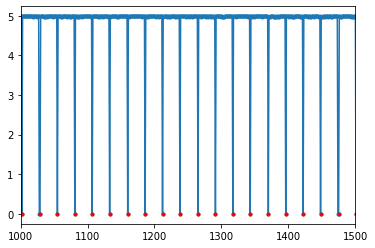

In [6]:
imgInd = np.where(np.diff(uvrDat.nidDf.imgfsig.values)>3)[0]
plt.plot(np.arange(0,len(uvrDat.nidDf.imgfsig.values)), uvrDat.nidDf.imgfsig, '.-')
plt.plot(np.arange(0,len(uvrDat.nidDf.imgfsig.values))[imgInd],
         uvrDat.nidDf.imgfsig[imgInd], 'r.')
plt.xlim(1000,1500)

In [7]:
imgFrame = uvrDat.nidDf.frame.values[imgInd].astype('int')
print(imgFrame)

#take only every x frame as start of volume
volFrame = imgFrame[0::imgMetadat['fpv']]
print(len(volFrame))
print(len(imgDat.wedge1))

[    2     3     4 ... 37211 37215 37218]
1400
1400


In [8]:
volFramePos = np.where(np.in1d(uvrDat.posDf.frame.values,volFrame, ))[0]
print(len(volFramePos))

1400


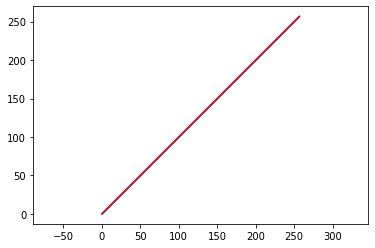

In [9]:
# sanity check to see if time values align
plt.plot(uvrDat.posDf.time.values[volFramePos],
         uvrDat.nidDf.timeinterp.values[imgInd[0::imgMetadat['fpv']]].astype('int') )
plt.plot(uvrDat.posDf.time.values[volFramePos],uvrDat.posDf.time.values[volFramePos],'r')
plt.axis('equal');

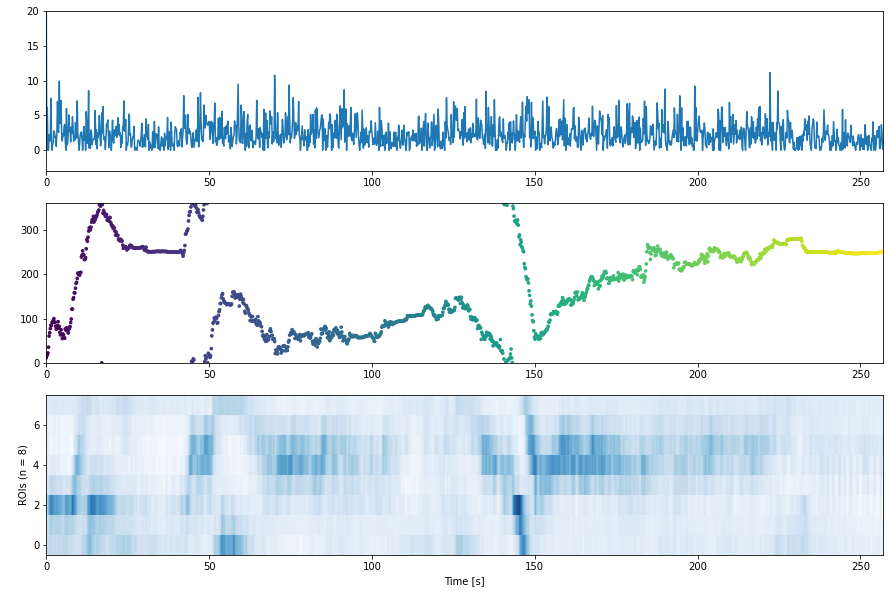

In [10]:
fig, axs = plt.subplots(3,1,figsize=(15,10))
axs[0].plot(uvrDat.posDf.time.values[volFramePos],
         np.hypot(uvrDat.posDf.dx.values,uvrDat.posDf.dy.values)[volFramePos]*10)
axs[0].set_ylim(-3,20)

#axs[1].plot(uvrDat.posDf.time.values[volFramePos],uvrDat.posDf.angle.values[volFramePos])
axs[1].scatter(uvrDat.posDf.time.values[volFramePos], uvrDat.posDf.angle.values[volFramePos],s=7,c=uvrDat.posDf.time.values[volFramePos],cmap='viridis')

axs[1].set_ylim(0,360)

cax = axs[2].pcolor(uvrDat.posDf.time.values[volFramePos],np.arange(0,8),
                 imgDat[["wedge{}".format(i+1) for i  in range(8)]].values.T,
                 cmap='Blues', edgecolors='face', shading='nearest')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('\nROIs (n = {0})'.format(8))

for ax in axs:
    ax.set_xlim(0,uvrDat.posDf.time.values[volFramePos[-1]])
    #myAxisTheme(ax)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
#cbar = fig.colorbar(cax)
#cbar.set_label('$(F - F_0) / F_0$ (per ROI)')  # vertically oriented colorbar

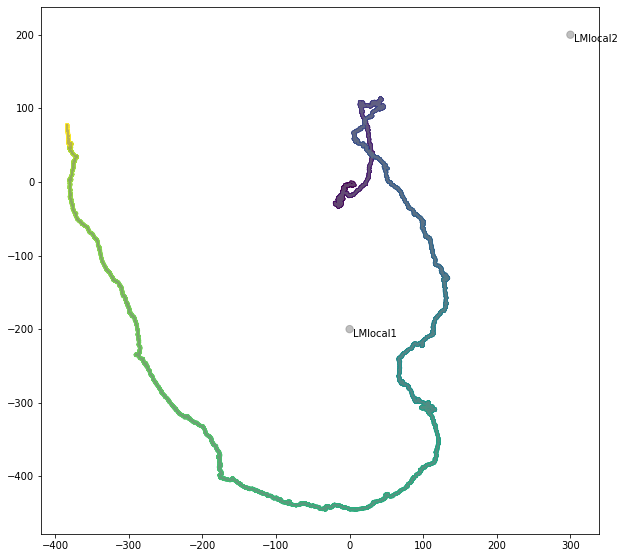

In [11]:
fig = viz.plotVRpathWithObjects(uvrDat, limx=np.inf, limy=np.inf,myfigsize=(10,10))